In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.inferences import VariationalInference
from edward.models import Bernoulli, Normal, RandomVariable
from edward.util import copy
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


ed.set_seed(42)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

In [2]:
# use custom helper functions from src folder
import sys
sys.path.insert(0, '../src/')

from data import *
from inference import *
from helpers import *
from model_zoo import conv_lstm 

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### DATA

In [3]:
# # for this basic example, lets only examine a small subset of the data
# %pdb on
# N = 10000  # number of data points
# D = 50  # number of features
# X_data, y_data, X_test, y_test = get_dataset(N=N,D=D, make_balanced=True)
# print('shapes (X,y),', X_data.shape, y_data.shape)

In [58]:
#new dataset with pca
from dataset import *
pca_comps = range(0,10)
dataset = DataSet(pca_comps=pca_comps, frac=1)
X_data, y_data, X_test, y_test = dataset.get_train_and_val()
print('shapes (X_data,y_data),', X_data.shape, y_data.shape)
print('dataset is balanced: y.mean =', y_data.mean())

Shapes:
X_train: (24996, 10)
training_data (25001, 13)
Index(['id', 'era', 'target', 'feature_prepro_0', 'feature_prepro_1',
       'feature_prepro_2', 'feature_prepro_3', 'feature_prepro_4',
       'feature_prepro_5', 'feature_prepro_6', 'feature_prepro_7',
       'feature_prepro_8', 'feature_prepro_9'],
      dtype='object')
x_prediction: (10001, 10)
shapes (X_data,y_data), (24996, 10) (24996,)
dataset is balanced: y.mean = 0.5


In [75]:
xypt

(9, 0.79000000000000004)

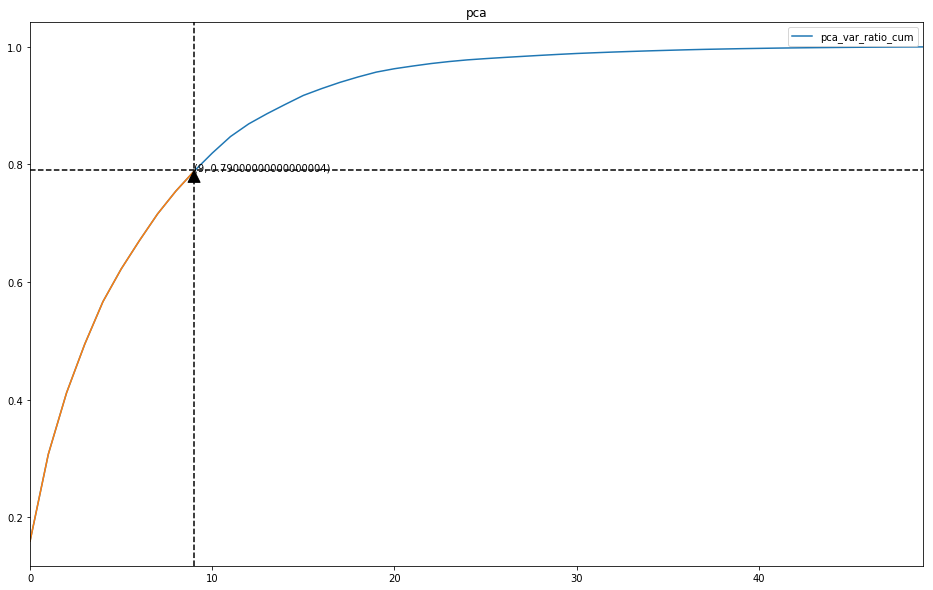

In [78]:
pca_cum_var_expl = pd.DataFrame({'pca_var_ratio_cum':dataset.pca.explained_variance_ratio_}).cumsum()
ax = pca_cum_var_expl.plot(title='pca')
xypt = (9, np.round(pca_cum_var_expl.loc[pca_comps].values[9][0],2))
ax.axvline(xypt[0], color='k', linestyle='--')
ax.axhline(xypt[1], color='k', linestyle='--')
ax.annotate(xypt, xy=xypt,
            arrowprops=dict(facecolor='black'),
            )
ax.plot(pca_comps, pca_cum_var_expl.values[0:10,0]);

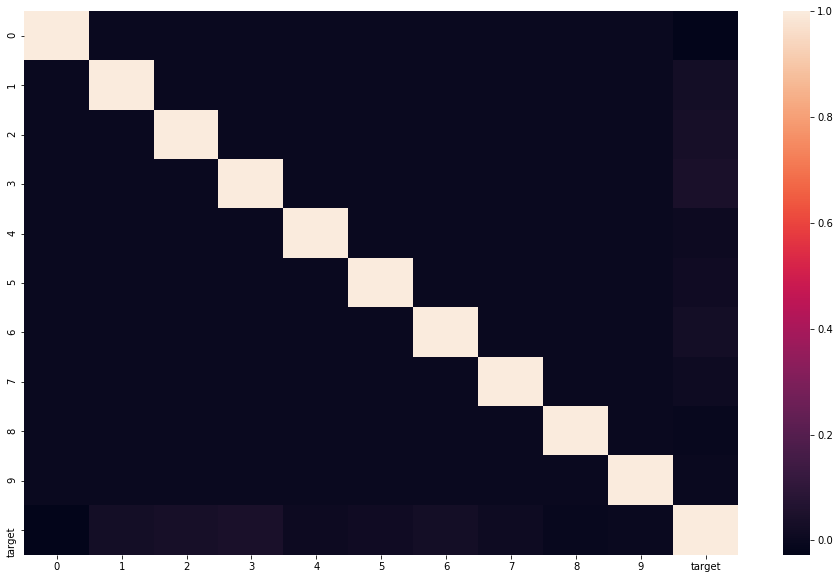

In [6]:
df = pd.DataFrame(X_data)
df['target'] = y_data
sns.heatmap(df.corr());
# title='correlation of features and binary target'

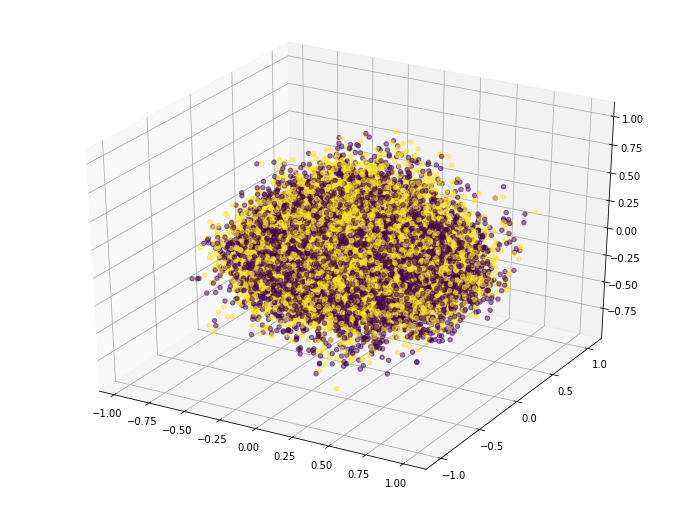

In [39]:
fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection='3d')
ax.scatter(X_data[:, 0], X_data[:, 1], X_data[:,2], c=y_data, alpha=.5);

In [8]:
M = 128    # batch size during training
y_ph = tf.placeholder(tf.int32, [None])
data = generator([X_data, y_data], M)    

In [9]:
D = X_data.shape[1]

### MODEL

In [10]:
X = tf.placeholder(tf.float32, [None , D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Bernoulli(logits=(ed.dot(X, w)+b))

### INFERENCE

In [11]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Helper functions to maximize the Evidence Lower bound (moved "log" outside compared to standard VAE)

$$ log(p(x)) >= -E_{q(z^1; \lambda), ..., q(z^K; \lambda)} [ \log \frac{1}{K} \sum_{k=1}^K \frac{p(x, z^k)}{q(z^k; \lambda)} ]$$

In [12]:
# inference = IWVI({w: qw,  b: qb}, data={X: X_data, y: y_data})
# inference.run(K=5, n_iter=10000, n_print=1)

alternatively, we use KLqp for batch learning

In [13]:
N = len(X_data)
n_batch = M
n_epoch = 2

inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize(n_iter=n_batch * n_epoch, n_samples=5, scale={y: N / M}, logdir='../log')
tf.global_variables_initializer().run()



info_dicts = []
for _ in range(inference.n_iter):
  X_batch, y_batch = next(data)
  info_dict = inference.update({X: X_batch, y_ph: y_batch})
  inference.print_progress(info_dict)
  info_dicts.append(info_dict)

256/256 [100%] ██████████████████████████████ Elapsed: 13s | Loss: 17540.818


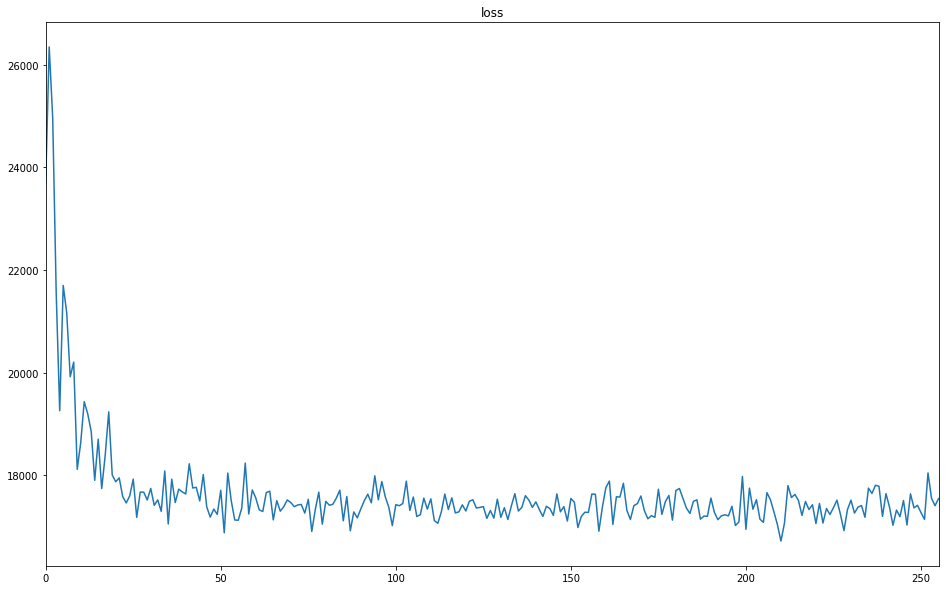

In [14]:
pd.Series([x['loss'] for x in info_dicts]).plot(title='loss');

### CRITICISM

In [15]:
y_post = ed.copy(y, {w: qw, b:qb})

#### todo: implemention of edward's logloss metric is buggy as it accepts predictions instead of logits
#### I've raised an issue here: https://github.com/blei-lab/edward/issues/795

In [16]:
for sam,Xx,yy in [("INS", X_data, y_data), ("OOS",X_test, y_test)]:
    print(sam)
    print("binary_acc:", ed.evaluate('binary_accuracy', data={X: Xx, y_post: yy}))
    print("binary_cross_entropy:", ed.evaluate('log_loss', data={X: Xx, y_post: yy}))  # todo bug in implementation

INS
binary_acc: 0.514482
binary_cross_entropy: 0.756553
OOS
binary_acc: 0.524448
binary_cross_entropy: 0.749929


In [17]:
print("log_loss:", ed.evaluate('log_loss', data={X: X_data, y_post: y_data})) # todo bug in implementation
print("categorical_crossentropy:", ed.evaluate('categorical_crossentropy', data={X: X_data, y_post: y_data}))
print("log_likelihood:", ed.evaluate('log_likelihood', data={X: X_data, y_post: y_data}))

log_loss: 0.75591
categorical_crossentropy: 127746.0
log_likelihood: -0.694135


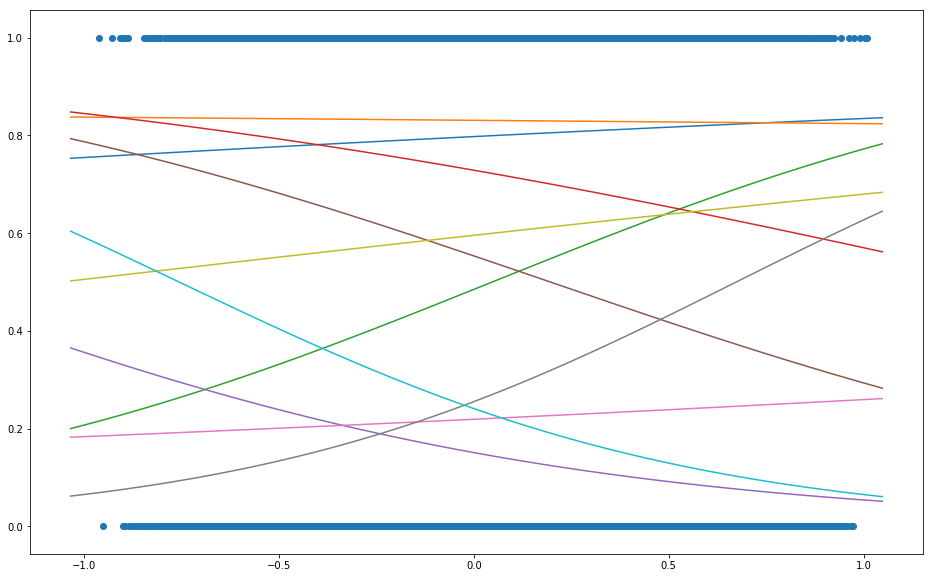

In [18]:
ww = visualise(X_data, y_data, w, b) #prior samples

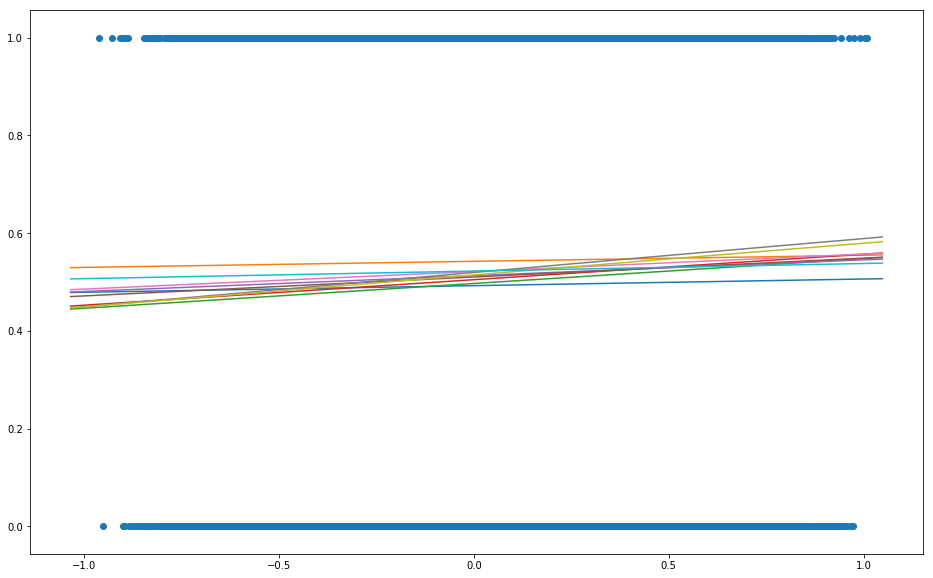

In [19]:
ww = visualise(X_data, y_data, qw, qb) #posterior samples

In [20]:
def binary_crossentropy(y_true, y_pred):
  """Binary cross-entropy.
  Args:
    y_ue: tf.Tensor.
      Tensor of 0s and 1s.
    y_pred: tf.Tensor.
      Tensor of real values (logit probabilities), with same shape as
      `y_true`.
  """
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))

In [21]:
from edward.util import check_data, get_session
from sklearn.metrics import log_loss

def get_y_preds(X_data, y_data, w, b, n_samples=10):
    w_samples = [w.eval() for _ in range(n_samples)]
    b_samples = [b.eval() for _ in range(n_samples)]
    return w_samples, b_samples

def eval_model(Xx, Yy, nom):
    ans = get_y_preds(Xx, Yy, qw, qb, n_samples=10000)
    zw, zb = np.mean(ans[0], axis=0), np.mean(ans[1], axis=0)
    probabilities = sigmoid(Xx.dot(zw) + zb)
    #probabilities = probabilities.clip(.49,.51)
    ins = pd.DataFrame(probabilities)
    ins['target'] = Yy
    ins['guess'] = ins[0].round().clip(0,1)
    print(nom, '\n------')
    print('acc:', (ins['target'] == ins['guess']).mean())
    print('sk.logloss:', log_loss(ins['target'], ins[0]))
    sess = get_session()
    print('ed.logloss (corrected):', sess.run(binary_crossentropy(ins['target'], -np.log(1/ins[0] -1)   )   ))
    print('ed.logloss (current):', sess.run(binary_crossentropy(ins['target'], ins[0]   )   ))

    print ('')
    return ins

ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

ins 
------
acc: 0.515162425988
sk.logloss: 0.693427597295
ed.logloss (corrected): 0.693428
ed.logloss (current): 0.724642

oos 
------
acc: 0.524747525247
sk.logloss: 0.693210927515
ed.logloss (corrected): 0.693211
ed.logloss (current): 0.723949



In [22]:
# see how eval metrics look under sample of maximum uncertainy

from edward.util import check_data, get_session
from sklearn.metrics import log_loss

preds = np.array([.5]*1000)
target = np.random.randint(0,2,1000)

print('acc:', (target == preds.round()).mean())
print('logloss:', log_loss(target, preds))
sess = get_session()
print('ed.logloss:', sess.run(binary_crossentropy(target, preds)))

x = preds
z = target
print('tf.doc.logloss', np.mean(x - x * z + np.log(1 + np.exp(-abs(x)))))

acc: 0.495
logloss: 0.69314718056
ed.logloss: 0.721576
tf.doc.logloss 0.72157698418


In [23]:
ins.describe()

,0,target,guess
count,24996.000000,24996.00000,24996.000000
mean,0.510377,0.50000,0.588374
std,0.043667,0.50001,0.492138
min,0.344206,0.00000,0.000000
25%,0.480452,0.00000,0.000000
50%,0.510167,0.50000,1.000000
75%,0.540500,1.00000,1.000000
max,0.684512,1.00000,1.000000


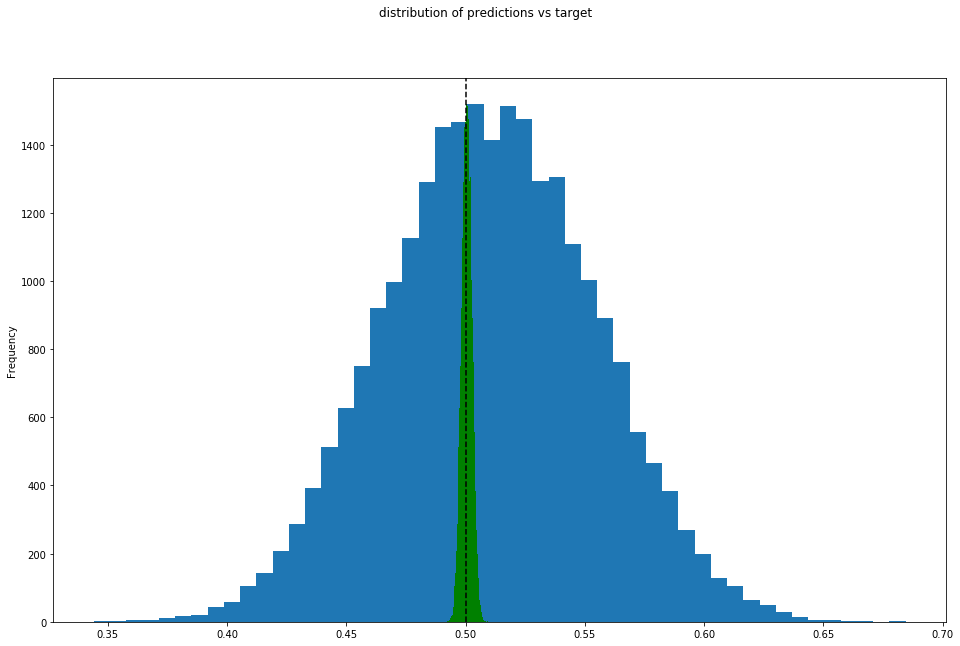

In [24]:
ax = ins[0].plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of predictions vs target', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
#ins['target'].plot(kind='hist', ax=ax[0], color='red', bins=50)

(((ins[0]-.5)*.05)+.5).plot(kind='hist', ax=ax[0], color='green', bins=50); # strinkage around 50%?

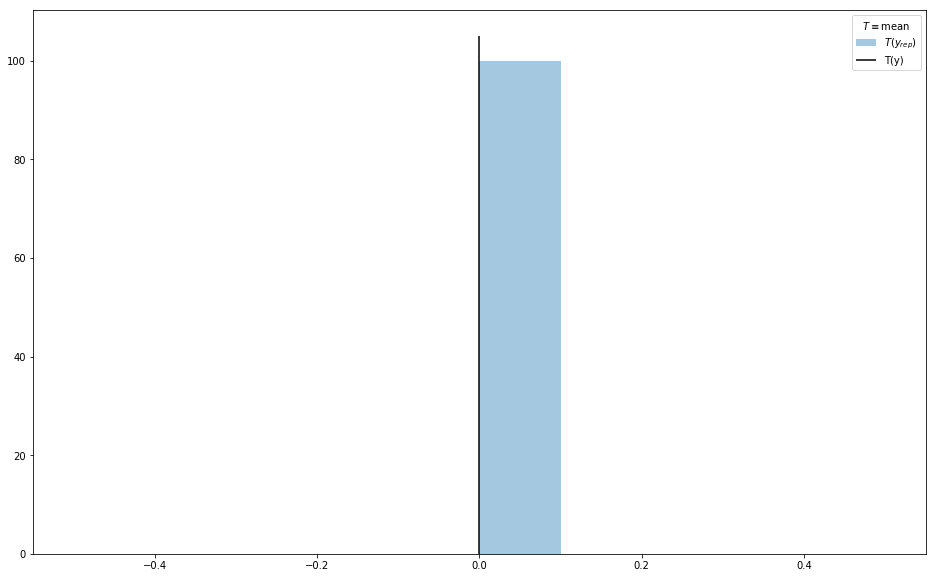

In [25]:
x_post = ed.copy(X, {w: qw, b: qb})

y_rep, y = ed.ppc(
    lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)),
    data={x_post: X_data})

ed.ppc_stat_hist_plot(
    y[0], y_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

In [26]:
ed.ppc(lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)), data={x_post: X_data})

[array([  7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
          7.63061558e-10,   7.63061558e-10,   7.63061558e-10,
        

In [27]:
def T(xs, zs):
    return tf.reduce_max(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_data, y_post: y_data})

In [28]:
qb.sample(50000).eval()

array([[-0.00915461],
       [-0.00739703],
       [ 0.00516907],
       ..., 
       [ 0.0889051 ],
       [ 0.06697073],
       [ 0.00156901]], dtype=float32)

In [29]:
## correlation with target is approxmently mean of posterior distribution on parameter

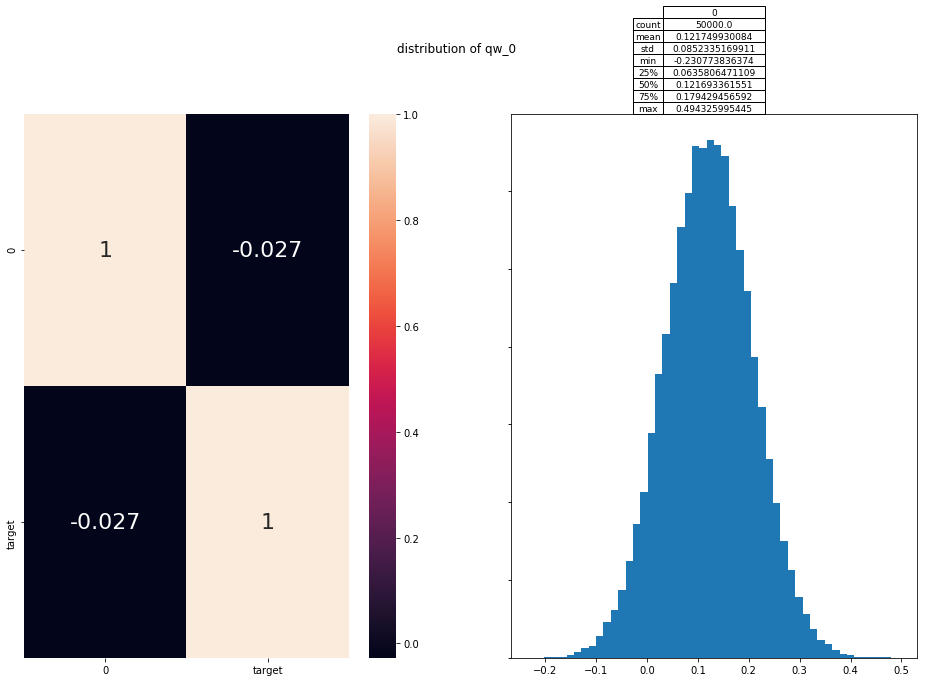

In [30]:
fig, axs = plt.subplots(1,2)


df = pd.DataFrame(X_data[:,0])
df['target'] = y_data
sns.heatmap(df.corr(), annot=True, ax=axs[0], annot_kws={'size':22})
dc = pd.Series(qw.sample(50000).eval()[:,0])
ax = dc.plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of qw_0', bins=50, ax=axs[1])

dcsummary = pd.DataFrame(dc.describe())
plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dcsummary.columns),
          rowLabels=dcsummary.index,
          colLabels=dcsummary.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='top');

In [31]:
dcsummary

,0
count,50000.000000
mean,0.121750
std,0.085234
min,-0.230774
25%,0.063581
50%,0.121693
75%,0.179429
max,0.494326


In [32]:
## ppc is 1 since y_data.mean() > 1?

In [33]:
y_data.mean()

0.5

In [34]:
ppc_max

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])]

### baseline comparison

We compare our results againist sklearn's Naive Bayes (BernoulliNB) and Logistic Regression (LogisticRegression, with sparsity regularization).

Note how BernoulliNB does well on the logloss metric but is a worse fit for the data, all the while LogisticRegression does well on the accurate prediction but poorly on the logloss metric. Our model using edward meets a happy medium between the two.

In [35]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import log_loss

print('NAIVE BAYES:')
clf = BernoulliNB()
clf.fit(X_data, y_data)

def get_preds(dat, shrink=False):
    preds = clf.predict_proba(dat)[:,1]
    if shrink:
        preds -= preds.mean()
        preds *= .3 #todo?
        preds += .5
    return preds

preds = get_preds(X_data)
print('ins:', (preds.round() == y_data).mean(), log_loss(y_data, preds))
preds = get_preds(X_test)
print('oos:', (preds.round() == y_test).mean(), log_loss(y_test, preds))
print('')
print('LOGISTIC REGRESSION:')
from sklearn import linear_model

regularization_C = 1e3 #lower == more regularization
clf = linear_model.LogisticRegression(C=regularization_C)
clf.fit(X_data, y_data)

def get_preds(dat, shrink=False):
    preds = clf.predict_proba(dat)[:,1]
    if shrink:
        preds -= preds.mean()
        preds *= .3 #todo?
        preds += .5
    return preds

preds = get_preds(X_data)
print('ins:', (preds.round() == y_data).mean(), log_loss(y_data, preds))
preds = get_preds(X_test)
print('oos:', (preds.round() == y_test).mean(), log_loss(y_test, preds))

NAIVE BAYES:
ins: 0.524723955833 0.691585992737
oos: 0.522147785221 0.69142507738

LOGISTIC REGRESSION:
ins: 0.5273243719 0.69024146527
oos: 0.532246775322 0.690317027703


In [36]:
print('bayesian-forecast')
print('--------')
ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

bayesian-forecast
--------
ins 
------
acc: 0.515082413186
sk.logloss: 0.693412780288
ed.logloss (corrected): 0.693413
ed.logloss (current): 0.724616

oos 
------
acc: 0.524647535246
sk.logloss: 0.693212245749
ed.logloss (corrected): 0.693213
ed.logloss (current): 0.723967



In [37]:
# # build posterior predictive after inference:
# # it is parameterized by a posterior sample
# x_post = ed.copy(x, {z: qz, beta: qbeta})

# # posterior predictive check
# # T is a user-defined function of data, T(data)
# T = lambda xs, zs: tf.reduce_mean(xs[x_post])
# ed.ppc(T, data={x_post: x_train})

# # in general T is a discrepancy function of the data (both response and
# # covariates) and latent variables, T(data, latent_vars)
# T = lambda xs, zs: tf.reduce_mean(zs[z])
# ed.ppc(T, data={y_post: y_train, x_ph: x_train},
#        latent_vars={z: qz, beta: qbeta})

# # prior predictive check
# # run ppc on original x
# ed.ppc(T, data={x: x_train})